# <center>Assignment 3<center>
<center>Allison Lau (23123849)<center>

# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import root_mean_squared_error, silhouette_score

# Tasks
## Reading the dataset

In [2]:
# Read dataset from csv file
dataset = pd.read_csv('housingCalifornia.csv')
print("Number of rows    :", dataset.shape[0])
print("Number of columns :", dataset.shape[1])

Number of rows    : 20640
Number of columns : 10


### D1 Exploratory data analysis and preprocessing
#### (a) Histograms

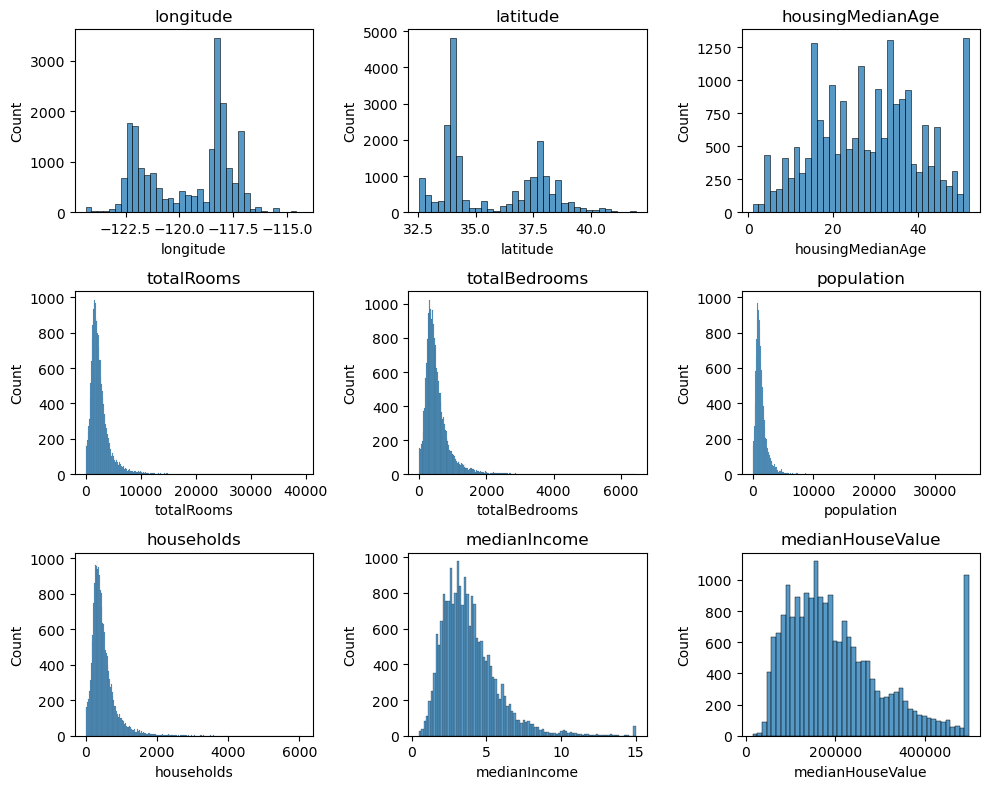

In [3]:
# Numerical columns + Target column
non_categorical = ['longitude', 'latitude', 'housingMedianAge', 'totalRooms', 'totalBedrooms', 'population', 'households', 'medianIncome', 'medianHouseValue']

# Create a grid subplot
fig, axes = plt.subplots(3, 3, figsize=(10, 8))
axes = axes.flatten()

# Plot histograms for non-categorical features and target
for i, col in enumerate(non_categorical):
    sns.histplot(dataset[col], ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

#### (b) Correlation matrix

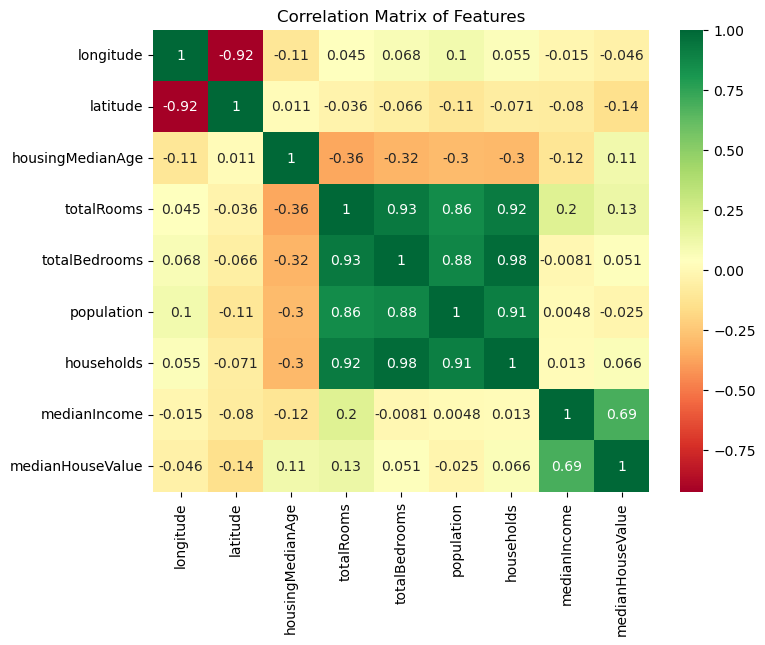

In [4]:
# Compute correlation matrix
correlation_matrix = dataset[non_categorical].corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn')
plt.title('Correlation Matrix of Features')
plt.show()

#### (c) Scatter plot

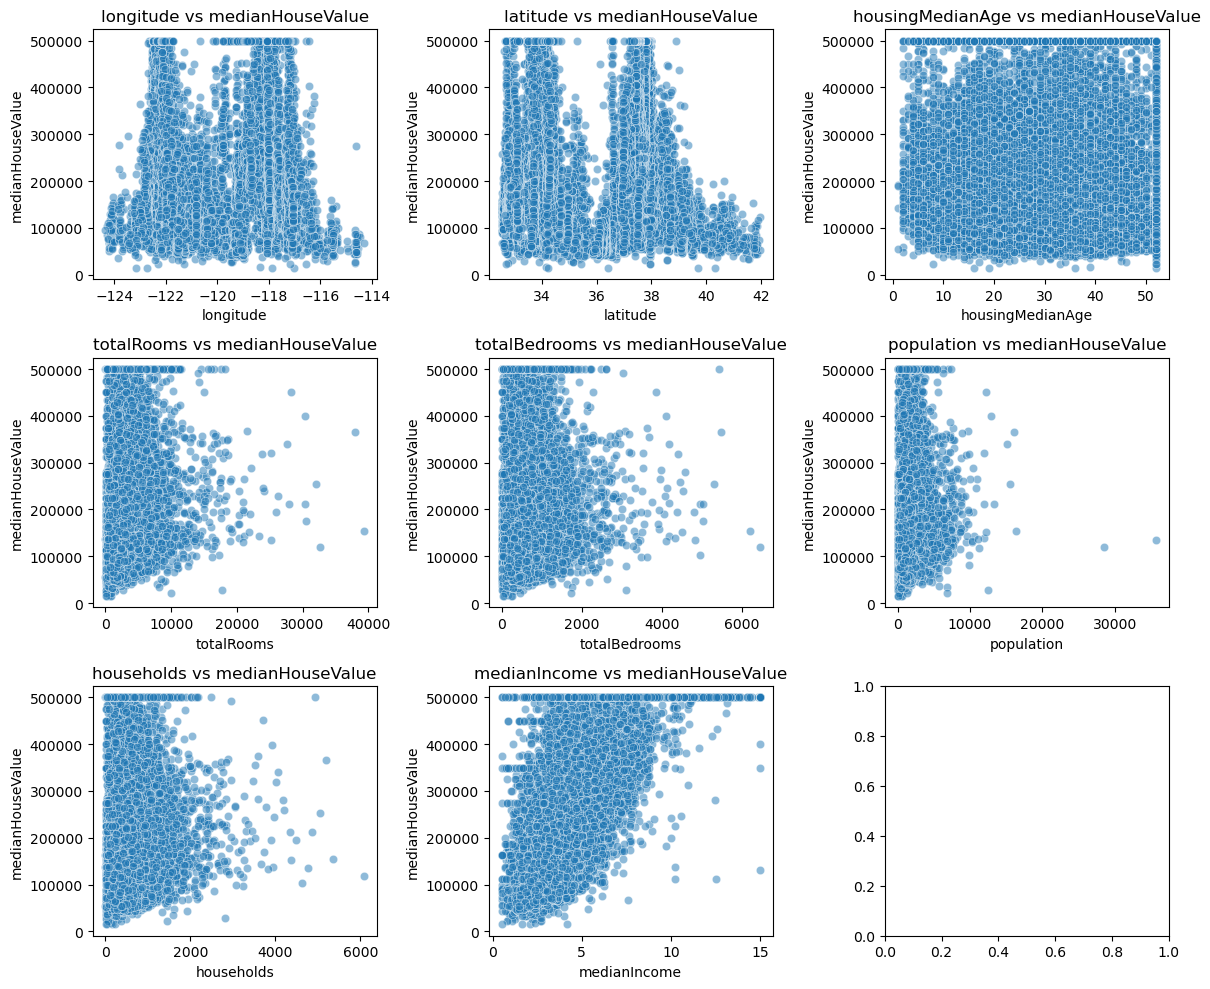

In [5]:
# Numerical columns
numerical_columns = ['longitude', 'latitude', 'housingMedianAge', 'totalRooms', 'totalBedrooms', 'population', 'households', 'medianIncome']

# Create a grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
axes = axes.flatten()

# Plot scatter plots for each numerical column against the target variable
for i, col in enumerate(numerical_columns):
    sns.scatterplot(x=col, y='medianHouseValue', data=dataset, ax=axes[i], alpha=0.5)
    axes[i].set_title(f'{col} vs medianHouseValue')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('medianHouseValue')

plt.tight_layout()
plt.show()

## Analysing the impact of different data transformations

In [6]:
# One-hot encode the 'oceanProximity' column
categorical = dataset[['oceanProximity']]
onehot_encoder = OneHotEncoder()
encoded = onehot_encoder.fit_transform(categorical)
encoded_array = encoded.toarray()

# Get the column names of the one-hot encoded features
categorical_columns = onehot_encoder.categories_[0]
reference_column = categorical_columns[0]
encoded_df = pd.DataFrame(encoded_array, columns=categorical_columns)

# Create dataset 1
data1 = pd.concat([dataset, encoded_df], axis=1)
data1.drop('oceanProximity', axis=1, inplace=True)
data1.drop(reference_column, axis=1, inplace=True)

# Make sure target column is at the end
data1_target_temp = data1['medianHouseValue']
data1 = data1.drop('medianHouseValue', axis=1)
data1['medianHouseValue'] = data1_target_temp

# Create dataset 2
data2 = data1.copy()
data2['medianHouseValue'] /= 100000.0

print("Shape of data1:", data1.shape)
print("Shape of data2:", data2.shape)

Shape of data1: (20640, 13)
Shape of data2: (20640, 13)


### D2 Split datasets and fit Linear Regression and Lasso Regression model

In [7]:
# Function to split and standardise the data
def split_and_standardise(data):
    # Split the dataset into features and target
    X = data.drop('medianHouseValue', axis=1)
    y = data['medianHouseValue']

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5508)

    # Standardise the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, X_train, X_test, y_train, y_test

# Function to fit Linear Regression model
def fit_linear_regression(X_train, y_train):
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    return lr_model

# Function to fit Lasso Regression model
def fit_lasso_regression(X_train, y_train, alpha):
    ls_model = Lasso(alpha=alpha, random_state=5508)
    ls_model.fit(X_train, y_train)
    return ls_model

# Function to calculate RMSE for training and testing sets
def calculate_rmse(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    rmse_train = root_mean_squared_error(y_train, y_train_pred)
    rmse_test = root_mean_squared_error(y_test, y_test_pred)
    return rmse_train, rmse_test

In [8]:
# Split data1 into training and test sets and standardise the datasets
X1_train_scaled, X1_test_scaled, X1_train, X1_test, y1_train, y1_test = split_and_standardise(data1)

# Split data2 into training and test sets and standardise the datasets
X2_train_scaled, X2_test_scaled, X2_train, X2_test, y2_train, y2_test = split_and_standardise(data2)

# Fit models on STANDARDISED data1
data1_linear_scaled = fit_linear_regression(X1_train_scaled, y1_train)
data1_lasso_scaled = fit_lasso_regression(X1_train_scaled, y1_train, alpha=100)

# Fit models on NON-STANDARDISED data1
data1_linear = fit_linear_regression(X1_train, y1_train)
data1_lasso = fit_lasso_regression(X1_train, y1_train, alpha=100)

# Fit models on STANDARDISED data2
data2_linear_scaled = fit_linear_regression(X2_train_scaled, y2_train)
data2_lasso_scaled = fit_lasso_regression(X2_train_scaled, y2_train, alpha=100)

# Fit models on NON-STANDARDISED data2
data2_linear = fit_linear_regression(X2_train, y2_train)
data2_lasso = fit_lasso_regression(X2_train, y2_train, alpha=100)

#### (a) Table of RMSE for training and test sets for both models for each dataset

In [9]:
# Calculate RMSE for standardised datasets (both models)
rmse1_train_linear_scaled, rmse1_test_linear_scaled = calculate_rmse(data1_linear_scaled, X1_train_scaled, y1_train, X1_test_scaled, y1_test)
rmse1_train_lasso_scaled, rmse1_test_lasso_scaled = calculate_rmse(data1_lasso_scaled, X1_train_scaled, y1_train, X1_test_scaled, y1_test)
rmse2_train_linear_scaled, rmse2_test_linear_scaled = calculate_rmse(data2_linear_scaled, X2_train_scaled, y2_train, X2_test_scaled, y2_test)
rmse2_train_lasso_scaled, rmse2_test_lasso_scaled = calculate_rmse(data2_lasso_scaled, X2_train_scaled, y2_train, X2_test_scaled, y2_test)

# Calculate RMSE for non-standardised datasets (both models)
rmse1_train_linear, rmse1_test_linear = calculate_rmse(data1_linear, X1_train, y1_train, X1_test, y1_test)
rmse1_train_lasso, rmse1_test_lasso = calculate_rmse(data1_lasso, X1_train, y1_train, X1_test, y1_test)
rmse2_train_linear, rmse2_test_linear = calculate_rmse(data2_linear, X2_train, y2_train, X2_test, y2_test)
rmse2_train_lasso, rmse2_test_lasso = calculate_rmse(data2_lasso, X2_train, y2_train, X2_test, y2_test)

# Display a table for RMSE values
table_data = [
    ["Original data1", rmse1_train_linear, rmse1_test_linear, rmse1_train_lasso, rmse1_test_lasso],
    ["Standardised data1", rmse1_train_linear_scaled, rmse1_test_linear_scaled, rmse1_train_lasso_scaled, rmse1_test_lasso_scaled],
    ["Original data2", rmse2_train_linear, rmse2_test_linear, rmse2_train_lasso, rmse2_test_lasso],
    ["Standardised data2", rmse2_train_linear_scaled, rmse2_test_linear_scaled, rmse2_train_lasso_scaled, rmse2_test_lasso_scaled]
]
table = pd.DataFrame(table_data, columns=['Type of Dataset', 'Linear Training RMSE', 'Linear Test RMSE', 'Lasso Training RMSE', 'Lasso Test RMSE'])
print(table.to_string(index=False))

   Type of Dataset  Linear Training RMSE  Linear Test RMSE  Lasso Training RMSE  Lasso Test RMSE
    Original data1          68607.314131      68589.312340         68660.504643     68601.809500
Standardised data1          68607.314131      68589.312340         68615.441095     68623.383563
    Original data2              0.686073          0.685893             1.129396         1.119761
Standardised data2              0.686073          0.685893             1.156303         1.144382


### D3 New features - Dataset 3

In [10]:
# Create dataset 3
data3 = data2.copy()
data3['meanRooms'] = data3['totalRooms'] / data3['households']
data3['meanBedrooms'] = data3['totalBedrooms'] / data3['households']
data3['meanOccupation'] = data3['population'] / data3['households']
deleted_columns = ['totalRooms', 'totalBedrooms', 'population', 'households']
data3 = data3.drop(deleted_columns, axis=1)     # Remove 4 columns

# Make sure target column is at the end
data3_target_temp = data3['medianHouseValue']
data3 = data3.drop('medianHouseValue', axis=1)
data3['medianHouseValue'] = data3_target_temp

# Split data3 into training and test sets and standardise the datasets
X3_train_scaled, X3_test_scaled, X3_train, X3_test, y3_train, y3_test = split_and_standardise(data3)

# Fit models on STANDARDISED data3
data3_linear_scaled = fit_linear_regression(X3_train_scaled, y3_train)
data3_lasso_scaled = fit_lasso_regression(X3_train_scaled, y3_train, alpha=100)

# Fit models on NON-STANDARDISED data3
data3_linear = fit_linear_regression(X3_train, y3_train)
data3_lasso = fit_lasso_regression(X3_train, y3_train, alpha=100)

#### (a) Table of RMSE for training and test sets for both models for each dataset

In [11]:
# Calculate RMSE for dataset 3 (both models)
rmse3_train_linear_scaled, rmse3_test_linear_scaled = calculate_rmse(data3_linear_scaled, X3_train_scaled, y3_train, X3_test_scaled, y3_test)
rmse3_train_lasso_scaled, rmse3_test_lasso_scaled = calculate_rmse(data3_lasso_scaled, X3_train_scaled, y3_train, X3_test_scaled, y3_test)

rmse3_train_linear, rmse3_test_linear = calculate_rmse(data3_linear, X3_train, y3_train, X3_test, y3_test)
rmse3_train_lasso, rmse3_test_lasso = calculate_rmse(data3_lasso, X3_train, y3_train, X3_test, y3_test)

# Display a table for RMSE values
table_data = [
    ["Original data3", rmse3_train_linear, rmse3_test_linear, rmse3_train_lasso, rmse3_test_lasso],
    ["Standardised data3", rmse3_train_linear_scaled, rmse3_test_linear_scaled, rmse3_train_lasso_scaled, rmse3_test_lasso_scaled],
]
table = pd.DataFrame(table_data, columns=['Type of Dataset', 'Linear Training RMSE', 'Linear Test RMSE', 'Lasso Training RMSE', 'Lasso Test RMSE'])
print(table.to_string(index=False))

   Type of Dataset  Linear Training RMSE  Linear Test RMSE  Lasso Training RMSE  Lasso Test RMSE
    Original data3               0.70949           1.13601             1.156303         1.144382
Standardised data3               0.70949           1.13601             1.156303         1.144382


#### (c) Estimated parameter values

In [12]:
# Function to print a model's coefficients with corresponding feature names
def print_coefficients(model, data):
    coefficients = model.coef_
    feature_names = data.columns[:-1]
    coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
    print(coefficients_df.to_string(index=False))

def print_model(print_models, data_models, data):
    
    for model in data_models:
        print(print_models[data_models.index(model)])
        print_coefficients(model, data)
        print("-" * 40)
    
print_models = ["Linear Regression (Original)", "Lasso Regression (Original)", "Linear Regression (Standardised)", "Lasso Regression (Standardised)"]
data1_models = [data1_linear, data1_lasso, data1_linear_scaled, data1_lasso_scaled]
data2_models = [data2_linear, data2_lasso, data2_linear_scaled, data2_lasso_scaled]
data3_models = [data3_linear, data3_lasso, data3_linear_scaled, data3_lasso_scaled]

# Print the coefficients of the models
print("Data1 Models " + ("~" * 30))
print_model(print_models, data1_models, data1)
print("Data2 Models " + ("~" * 30))
print_model(print_models, data2_models, data2)
print("Data3 Models " + ("~" * 30))
print_model(print_models, data3_models, data3)

Data1 Models ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Linear Regression (Original)
         Feature   Coefficient
       longitude -26533.237894
        latitude -25444.910842
housingMedianAge   1055.900145
      totalRooms     -6.428986
   totalBedrooms    102.935752
      population    -36.351577
      households     45.130509
    medianIncome  39305.206768
          INLAND -39134.844696
          ISLAND 153585.701929
        NEAR BAY   -791.470246
      NEAR OCEAN   4935.322875
----------------------------------------
Lasso Regression (Original)
         Feature   Coefficient
       longitude -26398.758516
        latitude -25420.759759
housingMedianAge   1059.841818
      totalRooms     -6.433659
   totalBedrooms    103.358469
      population    -36.404325
      households     44.807397
    medianIncome  39291.424531
          INLAND -38755.038140
          ISLAND      0.000000
        NEAR BAY     -0.000000
      NEAR OCEAN   4206.629661
----------------------------------------
Linear Regr

## Analysing the impact of different models
### D4 Lasso Regression using 10-fold cross-validation for Dataset 3

In [13]:
alpha_values = [0.0000001, 0.000001, 0.00001, 0.001, 0.001, 0.01, 0.1, 1, 10, 100]

# Perform 10-fold cross-validation with GridSearchCV
lasso_reg = Lasso(random_state=5508)
pg_lasso = {'alpha': alpha_values}
grid_search_lasso = GridSearchCV(lasso_reg, pg_lasso, cv=10, scoring='neg_mean_squared_error')
grid_search_lasso.fit(X3_train_scaled, y3_train)

GridSearchCV(cv=10, estimator=Lasso(random_state=5508),
             param_grid={'alpha': [1e-07, 1e-06, 1e-05, 0.001, 0.001, 0.01, 0.1,
                                   1, 10, 100]},
             scoring='neg_mean_squared_error')

#### (a) Report results

In [14]:
# Get the optimal alpha value according to grid search
best_params_lasso = grid_search_lasso.best_params_
best_alpha_lasso = best_params_lasso['alpha']

# Calculate RMSE for the best estimator
best_estimator_lasso = grid_search_lasso.best_estimator_
rmse_train_lasso, rmse_test_lasso = calculate_rmse(best_estimator_lasso, X3_train_scaled, y3_train, X3_test_scaled, y3_test)

# Report results
print(f"Optimal alpha value : {best_alpha_lasso}")
print(f"Training set RMSE   : {rmse_train_lasso}")
print(f"Test set RMSE       : {rmse_test_lasso}")
print("Estimated Parameters for each Feature")
print_coefficients(best_estimator_lasso, data3)

Optimal alpha value : 0.01
Training set RMSE   : 0.7157797606049322
Test set RMSE       : 1.0706729147375178
Estimated Parameters for each Feature
         Feature  Coefficient
       longitude    -0.246387
        latitude    -0.240308
housingMedianAge     0.103832
    medianIncome     0.724969
          INLAND    -0.274275
          ISLAND     0.019529
        NEAR BAY     0.017847
      NEAR OCEAN     0.031162
       meanRooms    -0.033403
    meanBedrooms     0.070794
  meanOccupation    -0.078468


### D5 Ridge Regression using 10-fold cross-validation for Dataset 3

In [15]:
# Perform 10-fold cross-validation with GridSearchCV
ridge_reg = Ridge(random_state=5508)
pg_ridge = {'alpha': alpha_values}
grid_search_ridge = GridSearchCV(ridge_reg, pg_ridge, cv=10, scoring='neg_mean_squared_error')
grid_search_ridge.fit(X3_train_scaled, y3_train)

GridSearchCV(cv=10, estimator=Ridge(random_state=5508),
             param_grid={'alpha': [1e-07, 1e-06, 1e-05, 0.001, 0.001, 0.01, 0.1,
                                   1, 10, 100]},
             scoring='neg_mean_squared_error')

#### (a) Report results

In [16]:
# Get the optimal alpha value according to grid search
best_params_ridge = grid_search_ridge.best_params_
best_alpha_ridge = best_params_ridge['alpha']

# Calculate RMSE for the best estimator
best_estimator_ridge = grid_search_ridge.best_estimator_
rmse_train_ridge, rmse_test_ridge = calculate_rmse(best_estimator_ridge, X3_train_scaled, y3_train, X3_test_scaled, y3_test)

# Report results
print(f"Optimal alpha value : {best_alpha_ridge}")
print(f"Training set RMSE   : {rmse_train_ridge}")
print(f"Test set RMSE       : {rmse_test_ridge}")
print("Estimated Parameters")
print_coefficients(best_estimator_ridge, data3)

Optimal alpha value : 100
Training set RMSE   : 0.7098876172951974
Test set RMSE       : 1.1314258937783133
Estimated Parameters
         Feature  Coefficient
       longitude    -0.438580
        latitude    -0.441902
housingMedianAge     0.106570
    medianIncome     0.781283
          INLAND    -0.204392
          ISLAND     0.027128
        NEAR BAY     0.021768
      NEAR OCEAN     0.032337
       meanRooms    -0.173267
    meanBedrooms     0.209397
  meanOccupation    -0.086887


### D6 Decision Tree Regression using 10-fold cross-validation for Dataset 3

In [17]:
max_depth_values = range(3, 15, 1)

# Perform 10-fold cross-validation with GridSearchCV
dt_reg = DecisionTreeRegressor(random_state=5508)
pg_dt = {'max_depth': max_depth_values}
grid_search_dt = GridSearchCV(dt_reg, pg_dt, cv=10, scoring='neg_mean_squared_error')
grid_search_dt.fit(X3_train_scaled, y3_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=5508),
             param_grid={'max_depth': range(3, 15)},
             scoring='neg_mean_squared_error')

#### (a) Report results

In [18]:
# Get the optimal alpha value according to grid search
best_params_dt = grid_search_dt.best_params_
best_max_depth_dt = best_params_dt['max_depth']

# Calculate RMSE for the best estimator
best_estimator_dt = grid_search_dt.best_estimator_
rmse_train_dt, rmse_test_dt = calculate_rmse(best_estimator_dt, X3_train_scaled, y3_train, X3_test_scaled, y3_test)

# Report results
print(f"Optimal max depth : {best_max_depth_dt}")
print(f"Training set RMSE : {rmse_train_dt}")
print(f"Test set RMSE     : {rmse_test_dt}")

Optimal max depth : 9
Training set RMSE : 0.5026714397455402
Test set RMSE     : 0.6015424327407188


### D8 Principle Component Analysis (PCA) in the training set using the standardised features for Dataset 3
#### (a) Plot of cumulative explained variance ratio against number of principal components

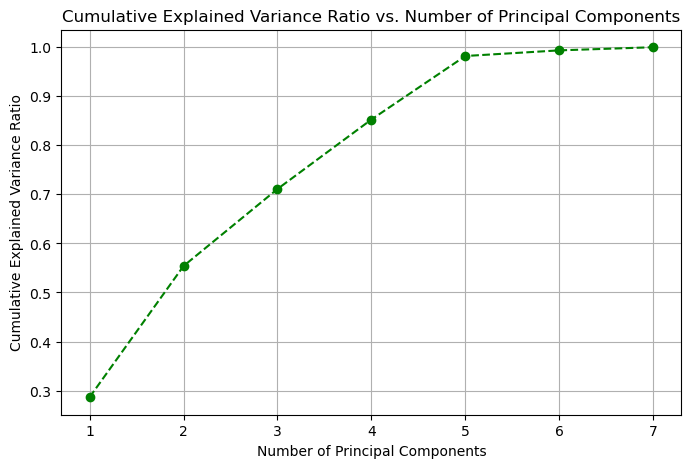

In [19]:
numerical = ['longitude', 'latitude', 'housingMedianAge', 'medianIncome', 'meanRooms', 'meanBedrooms', 'meanOccupation', 'medianHouseValue']

# Split data into training and test sets and standardise the datasets
X_train_scaled, X_test_scaled, X_train, X_test, y_train, y_test = split_and_standardise(data3[numerical])

# Apply PCA on the standardised features
pca = PCA(random_state=5508)
X_train_pca = pca.fit_transform(X_train_scaled)

# Plot the cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
num_components = range(1, len(cumulative_variance_ratio) + 1)
plt.figure(figsize=(8, 5))
plt.plot(num_components, cumulative_variance_ratio, marker='o', linestyle='--', color='g')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Principal Components')
plt.grid(True)
plt.show()

#### (b) Number of principal components required to preserve at least 90% of the variance

In [20]:
# Determine the number of principal components necessary to preserve at least 90% of the variance
n_components_90 = np.argmax(cumulative_variance_ratio >= 0.90) + 1
print("Number of Principal Components to Preserve 90% of Variance:", n_components_90)

Number of Principal Components to Preserve 90% of Variance: 5


#### (c) Linear Regression using selected number of principal components and report results

In [21]:
# Train a Linear Regression model using the selected number of principal components
pca_selected = PCA(n_components=n_components_90, random_state=5508)
X_train_pca_selected = pca_selected.fit_transform(X_train_scaled)
X_test_pca_selected = pca_selected.transform(X_test_scaled)

# Train a Linear Regression model
linear_pca = LinearRegression()
linear_pca.fit(X_train_pca_selected, y_train)

# Calculate RMSE for the training and test data
rmse_train_pca, rmse_test_pca = calculate_rmse(linear_pca, X_train_pca_selected, y_train, X_test_pca_selected, y_test)

# Report results
print(f"Training set RMSE   : {rmse_train_pca}")
print(f"Test set RMSE       : {rmse_test_pca}")

Training set RMSE   : 0.8058705407640099
Test set RMSE       : 1.3394144069946134


#### (d) Optimal number of principal components using 10-fold cross-validation

In [22]:
n_components = np.arange(1, X_train_scaled.shape[1] + 1)

pipeline_pca = Pipeline([
    ('pca', PCA(random_state=5508)),
    ('linear_reg', LinearRegression())
])

pg_pca = {
    'pca__n_components': n_components
}

# Perform 10-fold cross-validation with GridSearchCV
grid_search_pca = GridSearchCV(pipeline_pca, pg_pca, cv=10, scoring='neg_mean_squared_error')
grid_search_pca.fit(X_train_scaled, y_train)

# Get the optimal number of principal components according to grid search
best_params_pca = grid_search_pca.best_params_
optimal_n_components = best_params_pca['pca__n_components']

# Train a Linear Regression model using the selected number of principal components
pca_optimal = PCA(n_components=optimal_n_components, random_state=5508)
X_train_pca_optimal = pca_optimal.fit_transform(X_train_scaled)
X_test_pca_optimal = pca_optimal.transform(X_test_scaled)

# Train a Linear Regression model
linear_pca_optimal = LinearRegression()
linear_pca_optimal.fit(X_train_pca_optimal, y_train)

# Calculate RMSE for the training and test data
rmse_train_pca_opt, rmse_test_pca_opt = calculate_rmse(linear_pca_optimal, X_train_pca_optimal, y3_train, X_test_pca_optimal, y3_test)

# Report results
print(f"Optimal number of principal components : {optimal_n_components}")
print(f"Training set RMSE   : {rmse_train_pca_opt}")
print(f"Test set RMSE       : {rmse_test_pca_opt}")


Optimal number of principal components : 7
Training set RMSE   : 0.7189383142730591
Test set RMSE       : 1.1783865331169352


## Clustering analysis
### D9 Create dataset 4 - dataset 3 without categorical variables

In [24]:
# Create dataset 4 (without categorical variables)
data4 = data3.copy()
data4 = data4.drop(categorical_columns[1:], axis=1)

# Standardise the data
scaler4 = StandardScaler()
data4_scaled = scaler4.fit_transform(data4)
data4_scaled = pd.DataFrame(data4_scaled, columns=data4.columns)

# Perform PCA on the standardised data
pca = PCA(n_components=2)
data4_pca = pca.fit_transform(data4_scaled)

# Function to plot dendogram of hierarchical clustering
def plot_dendrogram(data, n_clusters, title=''):
    Z = linkage(data, method='average', metric='euclidean')
    plt.figure(figsize=(12, 8))
    dendrogram(Z, truncate_mode='lastp', p=n_clusters, show_leaf_counts=True)
    plt.title(f'Hierarchical Clustering Dendrogram {title}')
    plt.xlabel('Sample Index or (Cluster Size)')
    plt.ylabel('Distance')
    plt.show()

# Function to get mean and size of each cluster
def hierarchical_clustering_mean(data, n_clusters):
    # Perform hierarchical clustering
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')
    clusters = clustering.fit(data)
    
    # Add cluster labels to the original data
    data_clustered = data.copy()
    data_clustered['cluster'] = clusters.labels_
    
    # Calculate the mean of the variables for each cluster
    cluster_means = data_clustered.groupby('cluster').mean()
    
    # Calculate the size of each cluster
    cluster_sizes = data_clustered['cluster'].value_counts().sort_index()
    
    return cluster_means, cluster_sizes

#### (a) Hierarchical clustering with average linkage and Euclidean distance with dataset 4

In [25]:
# Plot the dendrogram
# plot_dendrogram(data4, 4)

# Perform hierarchical clustering and get mean and size for each cluster
cluster_means, cluster_sizes = hierarchical_clustering_mean(data4, 4)

# Print results
print("Mean of the variables for each cluster")
print(cluster_means.T.to_string())
print("~" * 100)
print("Size of each cluster")
print(cluster_sizes.to_string())

Mean of the variables for each cluster
cluster                    0            1           2           3
longitude        -119.569411  -121.980000 -120.605000 -121.150000
latitude           35.631367    38.320000   37.865000   38.690000
housingMedianAge   28.636364    45.000000   41.000000   52.000000
medianIncome        3.870154    10.226400    4.890900    6.135900
meanRooms           5.428809     3.166667    7.109890    8.275862
meanBedrooms        1.096655     0.833333    1.225275    1.517241
meanOccupation      2.946435  1243.333333  551.087912  230.172414
medianHouseValue    2.068581     1.375000    2.087500    2.250000
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Size of each cluster
cluster
0    20636
1        1
2        2
3        1


#### (b) Hierarchical clustering with average linkage and Euclidean distance with standardised dataset 4

In [26]:
# Plot the dendrogram
# plot_dendrogram(data4_scaled, 4, '(Standardised Data)')

# Perform hierarchical clustering and get mean and size for each cluster
cluster_means, cluster_sizes = hierarchical_clustering_mean(data4_scaled, 4)

# Print results
print("Mean of the variables for each cluster")
print(cluster_means.T.to_string())
print("~" * 100)
print("Size of each cluster")
print(cluster_sizes.to_string())

Mean of the variables for each cluster
cluster                  0          1          2           3
longitude         0.000134  -0.516748  -0.259695   -1.203053
latitude         -0.000309   1.045525   1.509030    1.258550
housingMedianAge -0.000196   0.982143   0.386207    1.299975
medianIncome     -0.000183   0.537026  -0.326708    3.345515
meanRooms        -0.005184   0.679391  53.268465   -0.914402
meanBedrooms     -0.005880   0.271365  60.677100   -0.555691
meanOccupation   -0.010897  52.766023  -0.048818  119.419103
medianHouseValue -0.000077   0.016415   1.078011   -0.601041
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Size of each cluster
cluster
0    20635
1        2
2        2
3        1


#### (c) k-means clustering (with k=4) with Euclidean distance with standardised dataset 4

In [27]:
initial_centroids = cluster_means.values

# Perform k-means clustering
n_clusters=4
kmeans = KMeans(n_clusters=n_clusters, init=initial_centroids, n_init=1, random_state=5508)
kmeans.fit(data4_scaled)

data4_clustered = data4_scaled.copy()
data4_clustered['kmeans_cluster'] = kmeans.labels_

# Calculate the mean of the variables for each k-means cluster
kmeans_cluster_means = data4_clustered.groupby('kmeans_cluster').mean()
kmeans_cluster_sizes = data4_clustered['kmeans_cluster'].value_counts().sort_index()

# Print results
print("Mean of the variables for each cluster")
print(kmeans_cluster_means.T.to_string())
print("~" * 100)
print("Size of each cluster")
print(kmeans_cluster_sizes.to_string())

Mean of the variables for each cluster
kmeans_cluster           0          1          2           3
longitude         0.000134  -0.516748  -0.259695   -1.203053
latitude         -0.000309   1.045525   1.509030    1.258550
housingMedianAge -0.000196   0.982143   0.386207    1.299975
medianIncome     -0.000183   0.537026  -0.326708    3.345515
meanRooms        -0.005184   0.679391  53.268465   -0.914402
meanBedrooms     -0.005880   0.271365  60.677100   -0.555691
meanOccupation   -0.010897  52.766023  -0.048818  119.419103
medianHouseValue -0.000077   0.016415   1.078011   -0.601041
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Size of each cluster
kmeans_cluster
0    20635
1        2
2        2
3        1


#### (d) Hierarchical clustering with average linkage and Euclidean distance on the first two principal component scores with standardised dataset 4 (PCA with 2 components)

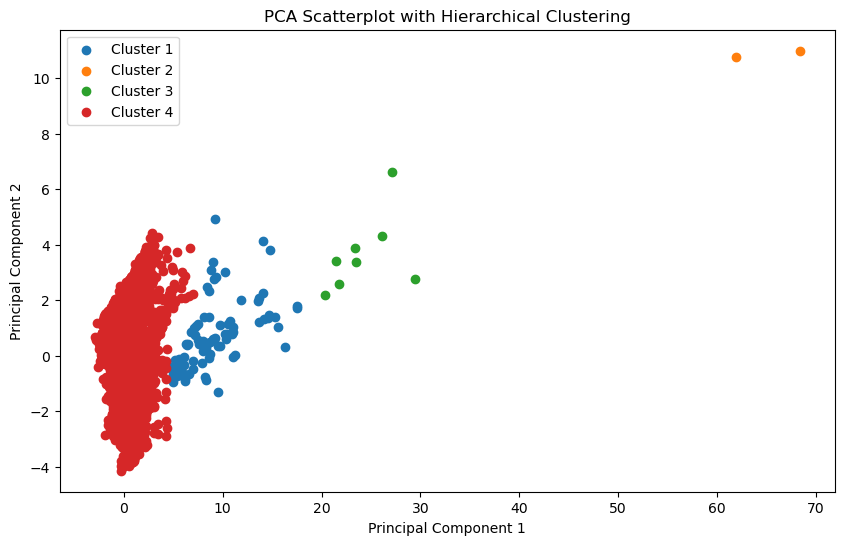

In [28]:
# Plot the dendrogram
# plot_dendrogram(data4_pca, 4, '(PCA)')

# Perform hierarchical clustering and get mean and size for each cluster
clustering_pca = AgglomerativeClustering(n_clusters=4, linkage='average')
clusters_pca = clustering_pca.fit(data4_pca)

# Scatterplot of the first two principal components with different colors for each cluster
plt.figure(figsize=(10, 6))
for i in range(4):
    x_scatter = data4_pca[clusters_pca.labels_ == i, 0]
    y_scatter = data4_pca[clusters_pca.labels_ == i, 1]
    plt.scatter(x_scatter, y_scatter, label=f'Cluster {i+1}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatterplot with Hierarchical Clustering')
plt.legend()
plt.show()

#### (e) k-means clustering (with k=4) with Euclidean distance on the first two principal component scores with standardised dataset 4 (PCA with 2 components)

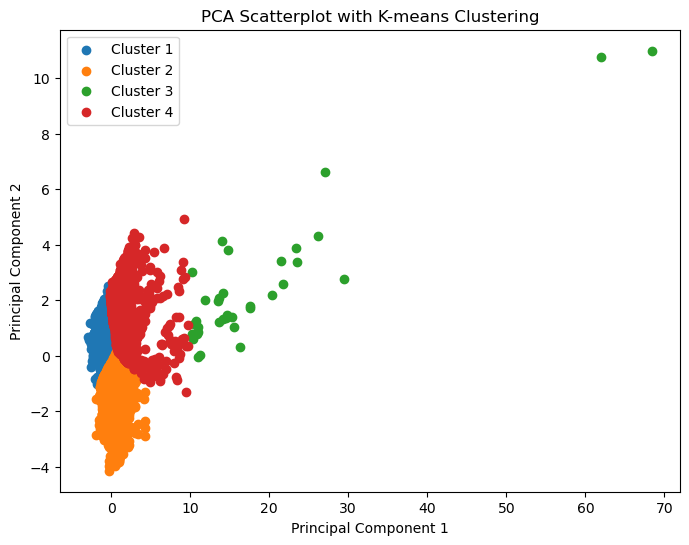

In [29]:
# Apply k-means clustering on the first two principal component scores
kmeans = KMeans(n_clusters=4, random_state=5508)
clusters_pca_kmeans = kmeans.fit(data4_pca)

# Scatterplot of the first two principal components with different colors for each cluster
plt.figure(figsize=(8, 6))
for i in range(4):
    x_scatter = data4_pca[clusters_pca_kmeans.labels_ == i, 0]
    y_scatter = data4_pca[clusters_pca_kmeans.labels_ == i, 1]
    plt.scatter(x_scatter, y_scatter, label=f'Cluster {i+1}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatterplot with K-means Clustering')
plt.legend()
plt.show()

### D10 Silhouette score for k-means clustering with k=2 to 20

In [30]:
k_values = range(2, 20, 1)
silhouette_scores = []

# Compute silhouette score for different values of k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=5508)
    clusters = kmeans.fit_predict(data4_scaled)
    silhouette_scores.append(silhouette_score(data4_scaled, clusters))

#### (a) Plot silhouette scores for different k values

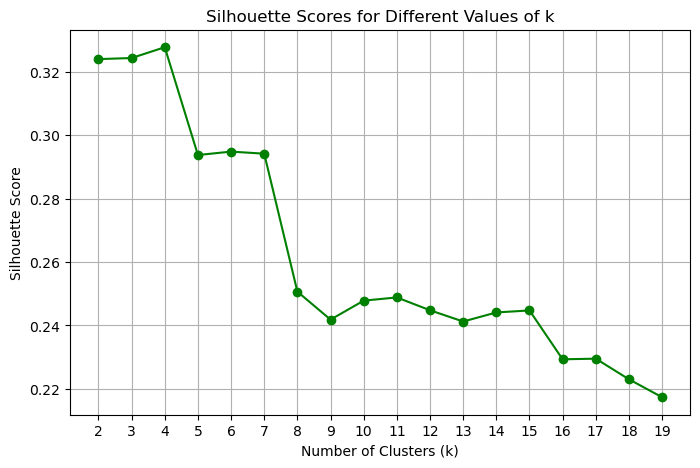

Optimal value of k for clustering: 4


In [31]:
# Plot silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', color='g')
plt.xticks(k_values)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Values of k')
plt.grid(True)
plt.show()

# Get the optimal k value (the highest silhouette score)
optimal_k = k_values[np.argmax(silhouette_scores)]
print(f"Optimal value of k for clustering: {optimal_k}")

#### (b) Plot 

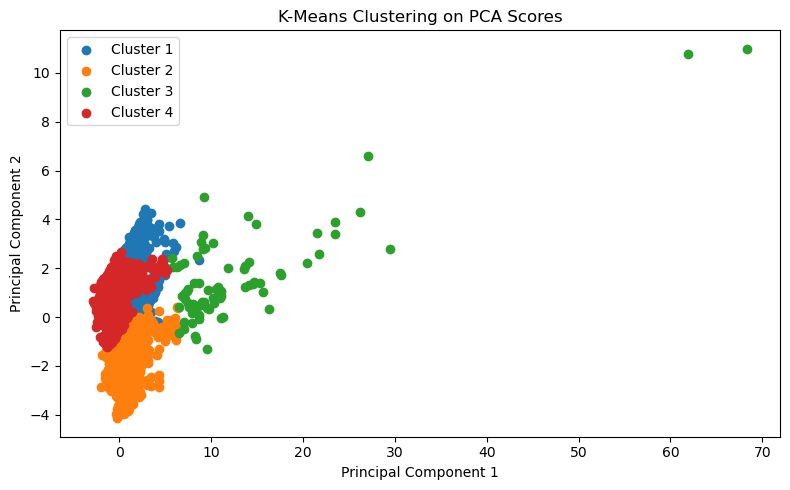

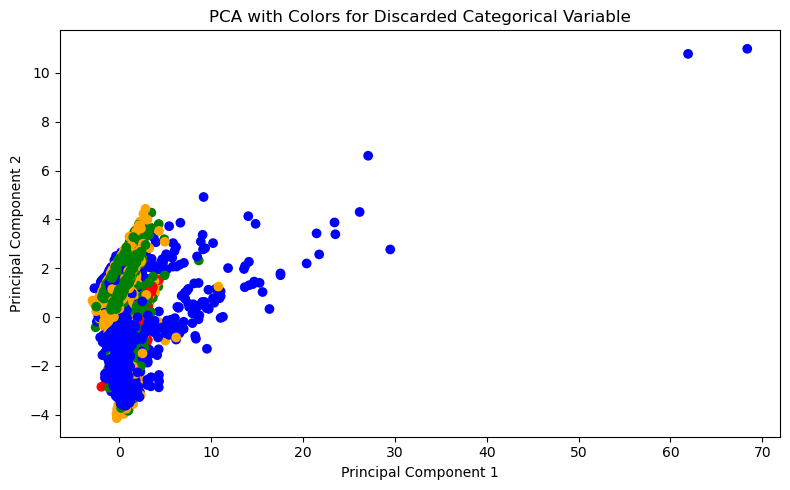

In [32]:
# Apply KMeans with the optimal k value
kmeans = KMeans(n_clusters=optimal_k, random_state=5508)
clusters = kmeans.fit(data4_scaled)

# Plot the k groups on the first two principal component scores
plt.figure(figsize=(8, 5))
for i in range(optimal_k):
    x_scatter = data4_pca[clusters.labels_ == i, 0]
    y_scatter = data4_pca[clusters.labels_ == i, 1]
    plt.scatter(x_scatter, y_scatter, label=f'Cluster {i+1}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering on PCA Scores')
plt.legend()
plt.tight_layout()
plt.show()

# Plot the first principal component scores with colors based on the deleted categorical variable
color_mapping = {
    'NEAR BAY': 'red', 
    '<1H OCEAN': 'green', 
    'INLAND': 'blue', 
    'NEAR OCEAN': 'orange', 
    'ISLAND': 'yellow'
}
color_labels = dataset['oceanProximity'].map(color_mapping)
plt.figure(figsize=(8, 5))
plt.scatter(data4_pca[:, 0], data4_pca[:, 1], c=color_labels)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA with Colors for Discarded Categorical Variable')
plt.tight_layout()
plt.show()